In [2]:
import numpy as np
import pandas as pd
import time
from datetime import datetime,timedelta
import json
import re

In [3]:
#根据log_index，增量读取log内容
def load_log(file_name, log_index):
    log_value_list = list()
    date_list = list()
    try:
        with open(file_name,'rb') as f:
            for index,content in enumerate(f):
                if index == log_index:
                    log_data = json.loads(content.decode('utf8'))
                    log_data['@timestamp'] = str(datetime.strptime(log_data['@timestamp'][0:19],'%Y-%m-%dT%H:%M:%S'))
                    log_value_list.append(log_data)
                    date_list.append(log_data['@timestamp'])
                    log_index += 1
    except Exception as e:
        print(e)
    #将文本内容转化为pandas的dataframe
    temp_log = pd.DataFrame(log_value_list, index=date_list)
    return  temp_log,log_index

In [4]:
#移动时间窗口，返回时间范围内新增的数据
def load_log_by_interval(all_log, time_windows, time_index):
    start_time = str(time_index)
    end_date = time_index + timedelta(seconds=time_windows) #根据时间窗口计算结束时间
    end_time = str(end_date)
    return all_log[start_time: end_time]
    

In [5]:
#根据正则表达式匹配字符串，reg：正则，check_str：待匹配字符串， 返回True，False
def reg_check(reg, check_str):
    result = re.search(reg,check_str,re.M|re.I) #正则表达式匹配
    if result:
        return True
    else:
        return False

In [6]:
#判断用户的操作类型（SQL注入、非支付平台访问、爬虫访问等不合法的网络入侵行为），生成一个用户行为矩阵并记录好用户的ip地址，ip地址使用user_op_list[x]["sip"]
'''
    每一列代表的意义（某时间窗内）：
    1.正常访问次数
    2.SQL注入
    3.非支付平台访问
    4.爬虫爬取
    5.不合理URI请求（请求非.do .js .css .html .jpg .png的地址）
    6.恶意挂马
'''
def cerate_one_hot_encodeing(temp_log_data):
    
    '''
        定义正则表达式匹配相关内容
    '''
    trojan_reg = r'<script(.+?)/script>|<style(.+?)/style>|<[^>]*>' #匹配request中嵌入的html，js，css,php代码   其他挂马暂时不知如何匹配
    pay_flatform_reg = r'Ali+|MicroMessenger|MQQBrowser' #^((?!XXX).)*$
    spider_reg = r'spiderman|Go-http-client'
    sql_reg = r'/(\%27)|(\')|(\-\-)|(\%23)|(#)/ix|/((\%3D)|(=))[^\n]*((\%27)|(\')|(\-\-)|(\%3B)|(:))/i|/\w*((\%27)|(\'))((\%6F)|o|(\%4F))((\%72)|r|(\%52))/ix|/((\%27)|(\'))union/ix(\%27)|(\')' #正则表达式匹配SQL语句
    illegal_url_reg = r'/.*\.(?:(?!(do|jpg|png|html|js|css)).)+/ ' #匹配除了.do .jpg .png .html .js .css之外的扩展名

    ip_list = list()
    temp_matrix = list()
    url_list = list()
    
    length =  len(temp_log_data.index)
    
    for x in range(0, length):
        if x+1 == length:
            break
        data = temp_log_data[x:x+1]
        #初始化各类初值，0-》无 1-》有1次某一次行为
        normal_visited, sql_flag, pay_flatform, spider, illegal_url, trojan = 0, 0, 0, 0, 0, 0 #对应的是正常访问，sql注入，非支付平台，爬虫，非合理url，挂马
        
        if reg_check(spider_reg, data["ua"].values[0]):
            spider = 1
        if reg_check(trojan_reg, data["request"].values[0]):
            trojan = 1
        if reg_check(illegal_url_reg, data["request"].values[0]):
            illegal_url = 1
        if not reg_check(pay_flatform_reg, data["ua"].values[0]) and spider==0:
            pay_flatform = 1
        if reg_check(sql_reg, data["request"].values[0]):
            sql_flag = 1
        
        if spider == 0 and trojan == 0 and illegal_url == 0 and pay_flatform == 0 and sql_flag == 0:
            normal_visited = 1
            
        url_str = data["request"].values[0].replace(' HTTP/1.1','')
        if url_str.find(' ') > -1:
            url_type = url_str[0 : url_str.find(' ')+1]
        if url_str.find('/') > -1 and url_str.find('?') > -1:
            url_str = url_type + url_str[url_str.find('/')+1 : url_str.find('?')]
        if url_str.find('/') > -1 and url_str.rfind('/') > -1:
            url_str = url_str[0 : url_str.find('/')] + '/.../' + url_str[url_str.rfind('/')+1 : ]
        
        #将全部ip 全部向量放入列表
        ip_list.append(str(data["sip"].values[0]))
        url_list.append(str(url_str))
        temp_matrix.append(np.array([normal_visited, sql_flag, pay_flatform, spider, illegal_url, trojan], dtype=int))
        
        '''
        if url_str == 'GET /.../1.1' or url_str == 'POST /.../1.1' or url_str == 'OPTIONS /.../1.1':
            file=open('url_str.txt', 'a')
            file.write(data["request"].values[0]+'\n')
            file.close()
        '''
        
    return ip_list, np.array(temp_matrix,dtype=int), url_list

In [7]:
# 得到时间窗口内所有ip操作矩阵的重复ip下标
def get_multiplicity_ip(ip_list):
    multiplicity_ip_dict = dict()
    for index,value in enumerate(ip_list):
        if value not in multiplicity_ip_dict.keys():
            multiplicity_ip_dict[value] = list()
        multiplicity_ip_dict[value].append(index)
    return multiplicity_ip_dict

In [8]:
#将得到的某1分钟数据合并并追加至总的矩阵中，返回总矩阵、ip_dict和ip_reserve_dict
def merge_vector(temp_matrix, temp_url_list, multiplicity_ip_dict, ip_dict, ip_reserve_list, all_matrix, all_url_list):
    for ip in multiplicity_ip_dict.keys():
        url_list = list()
        index = int(all_matrix.shape[0])
        number = np.array([0,0,0,0,0,0], dtype=int)
        for ip_index in multiplicity_ip_dict[ip]:
            number += temp_matrix[ip_index]
            url_list.append(temp_url_list[ip_index])
        all_matrix = np.concatenate((all_matrix,np.array([number],dtype=int)), axis=0)
        
        ip_reserve_list.append(ip)
        all_url_list.append(url_list)
        if ip not in ip_dict.keys():
            ip_dict[ip] = list()
        if index not in ip_dict[ip]:
            ip_dict[ip].append(index)
        
    return all_matrix, ip_dict, ip_reserve_list, all_url_list

In [9]:
#拼接数据，自行把每个小的矩阵读取出来，然后合并撑大的
def create_data_by_time_range(all_log, start_time, end_time, time_step, time_windows):
    global ip_dict, ip_reserve_list, all_matrix, all_url_list
    #每隔time_step秒读取一次日志，未实现
    #all_log, log_index = load_log('access_api_shunnengnet_com_json.log')
    start_date = datetime.strptime(start_time,'%Y-%m-%d %H:%M:%S')
    end_date = datetime.strptime(end_time,'%Y-%m-%d %H:%M:%S')
    
    while True:
        if start_date > end_date:
            break
        #增加判断，防止获取的数据内容超出时间窗口
        next_date = start_date + timedelta(seconds=time_step)
        if next_date > end_date:
            time_windows = (next_date - end_date).seconds
        temp_log_data = load_log_by_interval(all_log, time_windows, start_date)
        #print (start_date, time_windows, temp_log_data.shape)
        ip_list, temp_matrix, temp_url_list = cerate_one_hot_encodeing(temp_log_data)
        multiplicity_ip_dict = get_multiplicity_ip(ip_list)
        all_matrix, ip_dict, ip_reserve_list, all_url_list = merge_vector(temp_matrix, temp_url_list, multiplicity_ip_dict, ip_dict, ip_reserve_list, all_matrix, all_url_list)
        #正常情况下下一次循环的开始时间应该是这次循环得到的next_date
        start_date = next_date
    
    return all_matrix, ip_dict, ip_reserve_list, all_url_list

In [10]:
#常量定义
time_step = 300 #每x秒读取一次log文件
time_windows = 300 #秒,时间窗口
ip_dict = dict() #ip与对应操作在矩阵的下标
ip_reserve_list = list() #操作矩阵下标对应的ip
all_matrix = np.empty([0, 6],dtype=int)  #操作矩阵
all_log = pd.DataFrame() #所有的日志数据
temp_log_data = pd.DataFrame() #某时间范围的日志数据
all_url_list = list()
time_index = '2017-07-10 06:25:08' #记录当前的时间
log_index = 0 #记录读到第几行了
ip_behavior_dict = dict() #记录每个ip每分钟请求的页面url

increment_log_data, log_index = load_log('0713_access_sdsl_shunnengnet_com_json.log', 0)
all_log = all_log.append(increment_log_data)

In [11]:
starttime = datetime.now()
all_matrix, ip_dict, ip_reserve_list, all_url_list = create_data_by_time_range(all_log, '2017-07-13 06:25:02', '2017-07-13 23:59:59', time_step, time_windows)
endtime = datetime.now()
print((endtime - starttime).seconds)

112


In [12]:
all_url_list

[['POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'GET common/.../patientList.do',
  'GET /.../patientinfo.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'POST /.../reserve.do'],
 ['GET arrangement/.../doctorInfo.do', 'POST /.../init.do'],
 ['POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDept.do'],
 ['POST common/.../chooseHospital.do',
  'GET common/.../chooseExpert.do',
  'GET common/.../deptList.do',
  'POST /.../getDept.do'],
 ['GET common/.../scheduleByDept.do', 'POST /.../scheduleByDept.do'],
 ['GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET 

In [66]:
all_matrix.shape

(23345, 6)

In [70]:
def find_all_index(arr,item):
    return [i for i,a in enumerate(arr) if a==item]

idx = 210
ip = ip_reserve_list[idx]
idxs = find_all_index(ip_reserve_list, ip)
print ('出现位置', list(idxs))
for i in idxs:
    print (all_matrix[i])
    print (all_url_list[i])
    print ('--------------------------------')

出现位置 [181, 210]
[14  0  0  0  0  0]
['GET common/.../notice.do', 'POST common/.../chooseHospital.do', 'GET common/.../chooseExpert.do', 'GET common/.../deptList.do', 'POST /.../getDept.do', 'GET common/.../deptList.do', 'POST /.../getDept.do', 'GET common/.../scheduleByDept.do', 'POST /.../scheduleByDept.do', 'POST /.../getDept.do', 'GET common/.../scheduleByDept.do', 'POST /.../scheduleByDept.do', 'GET common/.../arrangementList.do', 'POST /.../getTimeList.do']
--------------------------------
[3 0 0 0 0 0]
['POST /.../scheduleByDept.do', 'GET common/.../arrangementList.do', 'POST /.../getTimeList.do']
--------------------------------


In [26]:
all_matrix[:,0]>30

array([13,  2,  3, ...,  1,  1,  1])

In [13]:
sum = 0
for value in ip_dict:
    sum = sum + len(ip_dict[value])
sum

12799

In [14]:
len(ip_reserve_list)

12799

In [ ]:
all_req_logs = list()
all_req_logs[577] = list()

In [29]:
all_matrix[577] = [..url,]

array([14,  0,  0,  0,  0,  0])

In [15]:
ip_reserve_list[:5]

['140.207.54.180',
 '123.134.92.105',
 '111.30.131.212',
 '112.38.171.235',
 '140.250.220.131']

In [25]:
total_access = all_matrix[:,0].sum()
a = np.zeros([50,2])
for i in range(50):
    t = (all_matrix[:,0]==i).sum()
    print(i,t, t*i, t*i/total_access)
    a[i,:] = [t*i, t*i/total_access]

0 4535 0 0.0
1 1123 1123 0.0140531341117
2 555 1110 0.0138904531291
3 420 1260 0.0157675413898
4 518 2072 0.025928845841
5 596 2980 0.037291486779
6 453 2718 0.0340128392837
7 504 3528 0.0441491158914
8 355 2840 0.0355395377357
9 355 3195 0.0399819799527
10 285 2850 0.0356646769531
11 337 3707 0.0463891078825
12 326 3912 0.0489544618388
13 349 4537 0.056775662925
14 254 3556 0.0444995057001
15 246 3690 0.046176371213
16 182 2912 0.0364405401009
17 157 2669 0.0333996571185
18 140 2520 0.0315350827796
19 169 3211 0.0401822027005
20 106 2120 0.0265295140844
21 114 2394 0.0299583286406
22 99 2178 0.0272553215452
23 82 1886 0.0236012563977
24 61 1464 0.0183203814243
25 50 1250 0.0156424021724
26 52 1352 0.0169188221897
27 49 1323 0.0165559184593
28 42 1176 0.0147163719638
29 40 1160 0.014516149216
30 39 1170 0.0146412884334
31 36 1116 0.0139655366595
32 30 960 0.0120133648684
33 18 594 0.00743326951233
34 15 510 0.00638210008635
35 16 560 0.00700779617324
36 11 396 0.00495551300822
37 9 333

In [26]:
import matplotlib.pyplot as plt # plt 用于显示图片
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


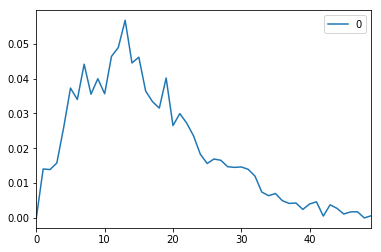

In [27]:
pd.DataFrame(a[:,1]).plot()

In [28]:
a[:,1].cumsum()

array([ 0.        ,  0.01405313,  0.02794359,  0.04371113,  0.06963997,
        0.10693146,  0.1409443 ,  0.18509342,  0.22063295,  0.26061493,
        0.29627961,  0.34266872,  0.39162318,  0.44839884,  0.49289835,
        0.53907472,  0.57551526,  0.60891492,  0.64045   ,  0.6806322 ,
        0.70716172,  0.73712005,  0.76437537,  0.78797662,  0.80629701,
        0.82193941,  0.83885823,  0.85541415,  0.87013052,  0.88464667,
        0.89928796,  0.91325349,  0.92526686,  0.93270013,  0.93908223,
        0.94609003,  0.95104554,  0.95521267,  0.95949244,  0.96193265,
        0.96593711,  0.97055474,  0.97108033,  0.97484702,  0.97760008,
        0.97872633,  0.98045325,  0.98221772,  0.98221772,  0.9828309 ])

In [21]:
X = all_matrix
y = np.zeros([X.shape[0], X.shape[1]],dtype='int32')
y[:,0] = X[:,0]>20 #超过20次访问（较高频的访问，占总访问量中10%视为异常）
y[:,1:] = X[:,1:]>0
X[:,1:] = X[:,1:]>0
print(y)
print(X)

[[0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 ..., 
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]]
[[0 0 1 0 0 0]
 [9 0 0 0 0 0]
 [0 0 1 0 0 0]
 ..., 
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]]


In [22]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)

C:\Users\Administrator\Anaconda3\envs\python35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [23]:
# 定义保存数据的类
import numpy as np

#定义类
class IPAccessInfo(object):
    def __init__(self, X, y, ip_dict, ip_reserve_list, data_scaler):
        self.X = X
        self.y = y
        self.ip_dict = ip_dict
        self.ip_reserve_list = ip_reserve_list
        self.data_scaler = data_scaler

In [24]:
# 保存文件为pkl
import pickle

iPAccessInfo = IPAccessInfo(X,y,ip_dict, ip_reserve_list, ss)
fp = open('iPAccessInfo.pkl','wb',True)
pickle.dump(iPAccessInfo, fp)

In [ ]:
hospital id from fact_dafds.
5*300
hospital -id -> from fact...[eos]

9 urls
9*100
auth->doctors->reserve->pay->number

Today I go to scholl ->   vector(1)   001 normal   010bad1  100 bad2


LSTM(normal)  sequence predict


memory:
    ip list[100]  url push stack 0-100  LSTM  --> 1 2 3
    

In [14]:
url_str = 'GET /hospital/api/c8ad630ed995424e8c3f21f843636d76/schedulesRemain?schDate=2017-07-10&deptId=%E5%A6%87%E7%A7%91%E4%B8%93%E4%B8%9A HTTP/1.1'

In [15]:
if url_str.find('/') > -1 and url_str.find('?') > -1:
    url_str = url_str[url_str.find('/')+1 : url_str.find('?')]
if url_str.find('/') > -1 and url_str.rfind('/') > -1:
    url_str = url_str[0 : url_str.find('/')] + '/.../' + url_str[url_str.rfind('/')+1 : ]

In [17]:
type(url_str)

str

In [18]:
li = list()

In [19]:
li.append(url_str)

In [20]:
li

['hospital/.../schedulesRemain']

In [102]:
templates = list() #总模板列表
templates.append(['a','b','get '])#普通预约
templates.append(['post ','asdfasdf','asdfasdf'])#普通预约
templates.append(['asddd','asdf','ji9adsf'])#普通预约
templates.append(['231','dasrf3','123d'])#普通预约

matched_operations = np.array([len(templates),1],dtype='float32')
for idx,template in enumerate(templates):
    n_template = len(template):
    count = 0
    for  str in template:
        if op_detail.has(str):
            count ++
    matched_operations[idx] = count/n_template

SyntaxError: invalid syntax (<ipython-input-102-ccda0da352b7>, line 9)

In [18]:
from keras.models import Sequential
from keras.layers import Embedding

#列出唯一的url
url_dict = dict()
for urls in all_url_list:
    for url in urls:
        if url not in url_dict.keys():
            url_dict[url] = 1
        else:
            url_dict[url] = url_dict[url] + 1
            
url_list = list(url_dict.keys())

#将url embedding，转为固定长度的向量
num_urls = len(url_list)
model = Sequential()
model.add(Embedding(num_urls, 32, input_length=1))
model.compile('rmsprop', 'mse')

input_array = np.array(range(num_urls))   #生成一个[num_url,1]的矩阵
output_array = model.predict(input_array)
print (output_array.shape)
print (output_array)

# 建立url_dict备查
url_dict = dict()
idx = 0
for url in url_list:
    url_dict[url] = output_array[idx,0,:]
    idx = idx + 1

(162, 1, 32)
[[[ 0.02079096  0.0395258  -0.02303337 ...,  0.02884394  0.00704154
   -0.03435834]]

 [[ 0.00896609 -0.0083899  -0.02701768 ...,  0.02910448  0.0390975
   -0.00350845]]

 [[-0.03234543 -0.04767251  0.00470174 ..., -0.01327963 -0.03058876
   -0.00910245]]

 ..., 
 [[-0.03530752  0.02587331  0.02203268 ..., -0.03739222 -0.03770877
   -0.03434356]]

 [[-0.00209799  0.02562338  0.04197837 ...,  0.03685788  0.01936198
   -0.04654149]]

 [[ 0.03161627 -0.04657397  0.03264802 ...,  0.00589434  0.04002989
    0.04446665]]]


In [22]:
def operations_to_sequence(all_url_list):
    operation_matrix = np.zeros((len(all_url_list),20,32))
    ip_operation_index = 0
    for ip_operations in all_url_list: #对于每小段窗口，以ip归类的urls集合
        ip_operation_url_index = 0
#         for url in ip_operations['urls']: 如果是dict字典的话
        for url in ip_operations:
            url_vector = url_dict[url]
            operation_matrix[ip_operation_index, ip_operation_url_index, :] = url_vector
            ip_operation_url_index = ip_operation_url_index + 1
            if ip_operation_url_index>=20:  #不超过20个长度的序列，可以改
                break
        ip_operation_index = ip_operation_index + 1
    return operation_matrix

operation_matrix = operations_to_sequence(all_url_list)
operation_matrix.shape   #数据编码结束

(23345, 20, 32)

In [20]:
n_class = 4
def label_operations(all_url_list):
    operation_label = np.zeros(len(all_url_list)) # 先按照0 1 2 3，一维数组排序
    ip_operation_index = 0
    for ip_operations in all_url_list: #对于每小段窗口，以ip归类的urls集合
        operation_label[ip_operation_index] = get_operation_label(ip_operations['ip'],ip_operations['time'])
        ip_operation_index + ip_operation_index + 1
        
    #转化为one-hot编码的label
    operation_label = operation_label.reshape(-1)
    operation_label = np.eye(n_class)[operation_label]
    return operation_label
#应该是(23345, 4)

(23345, 20, 32)

In [23]:
operation_matrix

array([[[ 0.02079096,  0.0395258 , -0.02303337, ...,  0.02884394,
          0.00704154, -0.03435834],
        [ 0.00896609, -0.0083899 , -0.02701768, ...,  0.02910448,
          0.0390975 , -0.00350845],
        [-0.03234543, -0.04767251,  0.00470174, ..., -0.01327963,
         -0.03058876, -0.00910245],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.02035362, -0.04947207, -0.0119575 , ...,  0.00568841,
          0.02845493,  0.01872641],
        [-0.014437  ,  0.02514464,  0.02848392, ..., -0.02887954,
         -0.01578576, -0.02390491],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,